# Simple MNIST NN from scratch

In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

Here's a video I made explaining all the math and showing my progress as I coded the network: https://youtu.be/w8yWXqWQYmU

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [76]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev= data_dev[0]
X_dev= data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [77]:
X_train[:,0].shape

(784,)

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Load and prepare data (assuming you have MNIST data loaded in 'data' variable)
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

# Neural Network Functions
def init_params():
    W1 = np.random.randn(10, 784) * 0.01
    b1 = np.zeros((10, 1))
    W2 = np.random.randn(10, 10) * 0.01
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(Z):
    return (Z > 0).astype(float)

def back_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2    

In [37]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration:", i)
            predictions = get_predictions(A2)
            print("Accuracy:", get_accuracy(predictions, Y))
    return W1, b1, W2, b2  

In [39]:
W1, b1, W2 ,b2 = gradient_descent(X_train, Y_train ,500 , 0.5)

Iteration: 0
Accuracy: 0.13587804878048781
Iteration: 10
Accuracy: 0.40295121951219515
Iteration: 20
Accuracy: 0.5813658536585365
Iteration: 30
Accuracy: 0.6846585365853659
Iteration: 40
Accuracy: 0.7200975609756097
Iteration: 50
Accuracy: 0.7048536585365853
Iteration: 60
Accuracy: 0.7452682926829268
Iteration: 70
Accuracy: 0.8086585365853659
Iteration: 80
Accuracy: 0.8226829268292682
Iteration: 90
Accuracy: 0.8576585365853658
Iteration: 100
Accuracy: 0.8583170731707317
Iteration: 110
Accuracy: 0.8115853658536586
Iteration: 120
Accuracy: 0.8928048780487805
Iteration: 130
Accuracy: 0.8970487804878049
Iteration: 140
Accuracy: 0.8947317073170732
Iteration: 150
Accuracy: 0.8739756097560976
Iteration: 160
Accuracy: 0.9049024390243903
Iteration: 170
Accuracy: 0.9064878048780488
Iteration: 180
Accuracy: 0.9067560975609756
Iteration: 190
Accuracy: 0.8771219512195122
Iteration: 200
Accuracy: 0.908829268292683
Iteration: 210
Accuracy: 0.9129268292682927
Iteration: 220
Accuracy: 0.914390243902439

~92% accuracy on training set.

Let's look at a couple of examples:

In [40]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def display_predictions(X, Y, W1, b1, W2, b2, num_images=25):
    plt.figure(figsize=(10, 10))
    predictions = make_predictions(X[:, :num_images], W1, b1, W2, b2)
    
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        image = X[:, i].reshape(28, 28) * 255
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title(f"Pred: {predictions[i]}\nTrue: {Y[i]}", fontsize=8)
    
    plt.tight_layout()
    plt.show()


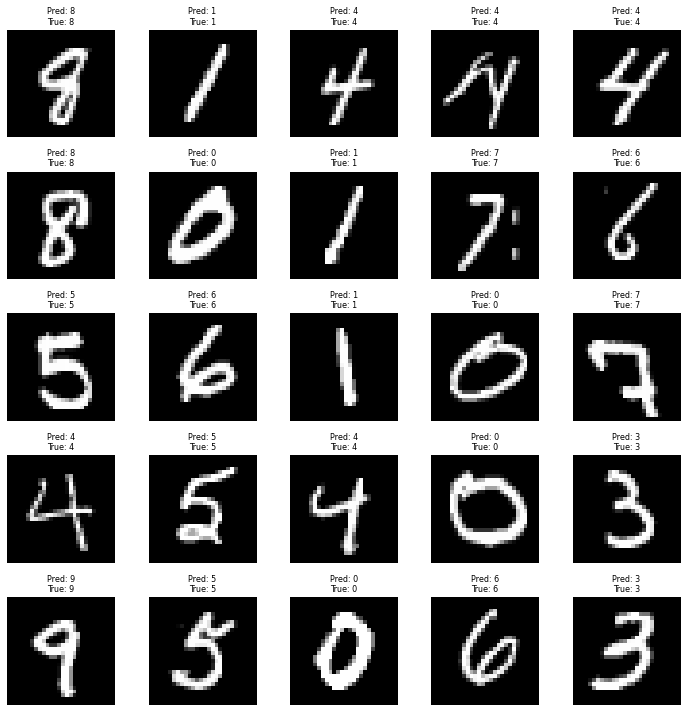

In [41]:
display_predictions(X_dev[:, :25], Y_dev[:25], W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [43]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

0.936

93% accuracy, so our model generalized from the training data pretty well.